<a href="https://colab.research.google.com/github/zia207/python-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-02-03-tree-based-models-bagging-cforest-python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 2.3 Conditional Random Forest (cforest)

Conditional Random Forest (cforest) builds on ensemble learning method that constructs multiple decision trees but uses **conditional inference trees** (implemented via the `ctree` algorithm) instead of standard CART (Classification and Regression Trees). These trees are based on a statistical framework that tests the independence between predictors and the response variable to guide splitting decisions. This notebook will cover the theoretical background, implementation details, and practical applications of cforest in R.

## Overview

A **Conditional Random Forest (cforest)** is an extension of the Random Forest algorithm that uses **conditional inference trees** as its base learners instead of standard decision trees. It was introduced to address some limitations of traditional Random Forests, particularly in handling variable selection bias and providing more robust statistical inference. The `cforest` algorithm is implemented in the R package `party` and is designed to work within a conditional inference framework, which ensures unbiased variable selection and better handling of complex data structures.

Key Features of cforest:

-   `Unbiased Variable Selection`: Unlike traditional Random Forests, which may favor variables with more categories or continuous variables, cforest uses conditional inference to select variables without bias.

-   `Statistical Rigor`: It incorporates permutation-based significance tests to decide splits, making it more robust for datasets with complex relationships or correlated predictors.

-`Flexibility`: cforest can handle various types of response variables (e.g., continuous, categorical, survival data) and is less sensitive to overfitting in certain scenarios.


### How Does Conditional Random Forest (cforest) Work?

The **Conditional Random Forest (cforest)** algorithm combines the ensemble approach of Random Forests with the **conditional inference framework** to reduce bias in variable selection and handle mixed data types effectively. Below is a detailed explanation, incorporating mathematical formulations where relevant:

1. Input Data

-   `Dataset`: Let $D = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$ be the dataset, where:

  -   $\mathbf{x}_i = (x_{i1}, x_{i2}, \dots, x_{ip})$ is a vector of $p$ predictor variables (numeric or categorical).

  -   $y_i$ is the response variable (continuous for regression, categorical for classification).

-   The goal is to predict $y$ given $\mathbf{x}$ using an ensemble of conditional inference trees.

2. Bootstrapping or Subsampling

-   `Bagging`: For each tree $t = 1, 2, \dots, T$, a bootstrap sample $D_t$ is drawn from $D$ with replacement, typically of size $n$. The probability that a specific observation $(\mathbf{x}_i, y_i)$ is included in $D_t$ is approximately $1 - (1 - 1/n)^n \approx 1 - e^{-1} \approx 0.632$.

-   `Subsampling`: Alternatively, a random subset of size $m< n$ is drawn without replacement. This reduces correlation between trees compared to bagging.

-   `Out-of-Bag (OOB) Sample`: Observations not included in $D_t$ form the OOB sample, used for estimating generalization error.

3.  Building Conditional Inference Trees

Each tree in cforest is a **conditional inference tree** (`ctree`), constructed using a statistical framework to ensure unbiased variable selection. The process involves:

3.1  `Variable Selection via Conditional Inference`:

  -   At each node, cforest tests the null hypothesis $H_0: Y \perp X_j \mid \mathbf{X}_{-j}$ for each predictor $X_j$, where $\mathbf{X}_{-j}$ denotes all other predictors.

    -   The test is based on a `permutation test`:

        -   Compute a test statistic (e.g., for regression, a correlation-based statistic; for classification, a chi-squared or Gini-based statistic).

        -   Permute the values of $X_j$ while keeping $Y$ and $\mathbf{X}_{-j}$ fixed to generate a null distribution.

        -   Calculate the p-value as the proportion of permuted test statistics exceeding the observed statistic:

$$  p_j = P(T(\mathbf{X}_j^{\text{perm}}, Y) \geq T(\mathbf{X}_j, Y) \mid \mathbf{X}_{-j}) $$

        
 - Select the predictor $X_j$ with the smallest p-value, provided $p_j < \alpha$ (e.g., $\alpha = 0.05$).

  - This ensures unbiased variable selection, unlike standard Random Forest, which may favor variables with more split points (e.g., continuous variables).


3.2 `Split Point Selection`:

  -   For the selected predictor $X_j$:

        -   If $X_j$ is continuous, evaluate split points $\in {x_{ij} \mid i \in \text{node}}$.

        -   If $X_j$ is categorical with levels ${c_1, c_2, \dots, c_k}$, consider all possible binary splits (e.g., ${c_1, c_2}$ vs. ${c_3, \dots, c_k}$).

    -   Choose the split that maximizes a test statistic, such as the standardized linear statistic:

$$  T_j(s) = \sum_{i \in \text{node}} w_i (y_i - \bar{y}) (x_{ij} - \bar{x}_j) \cdot I(x_{ij} \leq s) $$

        
 where $w_i $ are weights (typically 1), and $I$ is the indicator function.


-   The split maximizes the separation of $Y$ values in the child nodes.

3.3  `Recursive Partitioning*`

   -   Split the node into two child nodes based on the selected variable and split point.

   -   Recursively apply the above steps to each child node until a stopping criterion is met.

3.4  `topping Criteria`:

  -   Stop splitting if:

       -   No predictor has a p-value $< \alpha$ (no significant association).

        -   The node size is below a threshold (e.g., $n_{\text{min}} = 10$).

        -   A maximum tree depth is reached.

    -   The terminal node assigns a prediction (e.g., mean $y$ for regression, majority class for classification).

4. Ensemble Prediction

-   `Regression`:

   -   For a new observation $\mathbf{x}$, each tree \$t \$ predicts $\hat{y}_t(\mathbf{x})$.

   -   The final prediction is the average across all trees:

$$ \hat{y}(\mathbf{x}) = \frac{1}{T} \sum_{t=1}^T \hat{y}_t(\mathbf{x}) $$

-   `Classification`:

  -   Each tree votes for a class $\hat{y}_t(\mathbf{x})$.
  -   The final prediction is the majority class or averaged class probabilities:

$$  \hat{y}(\mathbf{x}) = \arg\max_c \left( \frac{1}{T} \sum_{t=1}^T I(\hat{y}_t(\mathbf{x}) = c) \right) $$

-   `OOB Error`:

   -   For each observation $(\mathbf{x}_i, y_i)$, use only trees where $(\mathbf{x}_i, y_i) \notin D_t$.

  -   Compute OOB predictions and estimate error (e.g., RMSE for regression, misclassification rate for classification).

5. Variable Importance

-   `Permutation Importance`:

  -   For predictor $X_j$, permute its values in the OOB sample for tree $t$.
  
  -   Compute the increase in OOB error (e.g., MSE for regression):

$$  \text{Importance}(X_j) = \frac{1}{T} \sum_{t=1}^T \left( \text{MSE}_{\text{perm},t} - \text{MSE}_{\text{orig},t} \right) $$

-   Higher values indicate greater importance.


Below is a flowchart illustrating the process of building a Conditional Random Forest (cforest):

![alt text](http://drive.google.com/uc?export=view&id=1nRfrCMuys21NkrUx43xOsJ_mkTSQDNyr)


### Comparison with Standard Random Forest

| **Aspect** | **Random Forest (CART)** | **Conditional Random Forest (cforest)** |
|------------------|---------------------------|---------------------------|
| **Base Learner** | CART (decision trees) | Conditional inference trees (`ctree`) |
| **Variable Selection** | Based on impurity (Gini, MSE) | Based on conditional inference (p-values) |
| **Bias in Splitting** | Biased toward variables with more categories | Unbiased, uses permutation tests |
| **Computational Speed** | Faster | Slower due to statistical tests |
| **Implementation** | Widely available (e.g., scikit-learn, R) | Primarily in R’s `partykit` package |
| **Interpretability** | Less statistically rigorous | More rigorous (p-value-based splits) |

## Conditional Random Forest (cforest) in Python

In Python, the equivalent of Conditional Random Forests (cforest)—which is a concept from the {partykit} package in R—can be approximated using the {sklearn} or {rpy2} libraries, though there is no direct implementation of cforest in native Python libraries.

The below ode provides a foundational implementation of `cforest` in Python, demonstrating the core concepts of conditional inference trees and ensemble learning as applied in the R {partykit} package.


### Coustom `cforest()` function

This code cell contains the implementation of a custom conditional random forest algorithm (`cforest`) and its supporting functions in Python.

Here's a breakdown of the key parts:

1.  **`Node and TreeData structures`**: These define the basic building blocks for the decision trees. `Node` represents a node in the tree with information about the split, children, and prediction. `TreeData` stores the model frame, variable information, and terms used in the model.

2.  **`aggregate_predictions`**: This function takes an array of predictions (from multiple trees) and aggregates them. For classification, it uses a majority vote, and for regression, it uses the mean.

3.  **`permutation_test`**: This function performs a permutation test to assess the independence between a predictor variable and the response variable. This is used in the tree splitting process to find the most significant split. It handles both classification (using chi-squared) and regression (using correlation).

4.  **`find_best_split`**: This function iterates through the available predictor variables and their unique values to find the best split point based on the permutation test p-value. It aims to find the split that results in the most significant separation of the response variable.

5.  **`build_tree`**: This is the core function for building a single conditional inference tree. It recursively splits the data based on the best split found by `find_best_split` until a stopping criterion is met (e.g., maximum depth, minimum samples in a node, or no significant split).

6.  **`ctree`**: This function serves as a wrapper to set up the data and call `build_tree` to create a single conditional inference tree. It handles formula parsing, data preparation, and determines the task type (classification or regression).

7.  **`constparties`, `nodeids`, `fitted_node`, `nodeprune`, `predict_tree`, `predict_forest`**: These are helper functions for managing the forest structure, extracting node information, making predictions from a single tree or the entire forest, and pruning nodes (though pruning is not actively used in the main `cforest` function as implemented here).

8.  **`compute_feature_importance` and `plot_feature_importance`**: These functions calculate and visualize the permutation-based feature importance for the trained random forest model.

9.  **`cforest`**: This is the main function that trains the conditional random forest. It takes the formula, data, number of trees (`ntree`), perturbation settings (`perturb`), number of variables to randomly sample at each split (`mtry`), and other control parameters. It builds multiple conditional inference trees in parallel and combines them into a forest model.

In essence, the code implements a conditional random forest, which is a type of ensemble learning method that builds multiple decision trees based on statistical tests to determine optimal splits, providing a potentially more robust and interpretable model compared to traditional random forests.

In [1]:
# Load necessary Python libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score
import progressbar
from collections import namedtuple
from scipy import stats
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from typing import Optional, List, Dict, Any, Union, Callable, Tuple
from pandas.api.types import CategoricalDtype


# Define Node structure
Node = namedtuple('Node', ['id', 'split_var', 'split_value', 'left', 'right', 'terminal', 'prediction'])

class TreeData:
    def __init__(self, model_frame: pd.DataFrame, variables: Dict, terms: Dict):
        self.model_frame = model_frame
        self.variables = variables
        self.terms = terms
        self.data = model_frame

def aggregate_predictions(arr: np.ndarray, task_type: str, default: Any = None) -> Any:
    arr = np.array([x for x in arr if x is not None], dtype=object if task_type == "classification" else float)
    if arr.size == 0:
        return default
    if task_type == "classification":
        unique, counts = np.unique(arr, return_counts=True)
        return unique[np.argmax(counts)]
    else:
        return np.mean(arr)

def permutation_test(x: np.ndarray, y: np.ndarray, task_type: str, n_perm: int = 50) -> Tuple[float, float]:
    x = x.astype(float)
    if task_type == "classification":
        y = y.astype(str)
        unique_x, x_idx = np.unique(x, return_inverse=True)
        unique_y, y_idx = np.unique(y, return_inverse=True)
        if len(unique_x) <= 1 or len(unique_y) <= 1:
            return 0.0, 1.0
        contingency = np.histogram2d(x_idx, y_idx, bins=(len(unique_x), len(unique_y)))[0]
        try:
            obs_stat, _, _, _ = stats.chi2_contingency(contingency, correction=False)
        except ValueError:
            return 0.0, 1.0
        perm_stats = np.zeros(n_perm)
        for i in range(n_perm):
            perm_y_idx = np.random.permutation(y_idx)
            perm_contingency = np.histogram2d(x_idx, perm_y_idx, bins=(len(unique_x), len(unique_y)))[0]
            perm_stats[i], _, _, _ = stats.chi2_contingency(perm_contingency, correction=False)
        p_value = np.mean(perm_stats >= obs_stat)
    else:
        y = y.astype(float)
        if len(np.unique(x)) <= 1 or len(np.unique(y)) <= 1:
            return 0.0, 1.0
        try:
            obs_stat = np.abs(np.corrcoef(x, y)[0, 1])
        except Exception:
            return 0.0, 1.0
        perm_stats = np.zeros(n_perm)
        for i in range(n_perm):
            perm_y = np.random.permutation(y)
            perm_stats[i] = np.abs(np.corrcoef(x, perm_y)[0, 1])
        p_value = np.mean(perm_stats >= obs_stat)
    return obs_stat, p_value

def find_best_split(X: np.ndarray, y: np.ndarray, indices: np.ndarray, task_type: str, n_jobs: int = -1, n_perm: int = 50) -> Tuple[Optional[int], Optional[float], float]:
    best_p = 1.0
    best_var = None
    best_value = None
    unique_values = []
    for i in range(X.shape[1]):
        vals = np.unique(X[indices, i])
        unique_values.append(vals if len(vals) > 0 else np.array([]))

    def test_variable(var_idx):
        x_var = X[indices, var_idx]
        stat, p_value = permutation_test(x_var, y[indices], task_type, n_perm=n_perm)
        return var_idx, p_value, unique_values[var_idx]

    results = Parallel(n_jobs=n_jobs)(delayed(test_variable)(i) for i in range(X.shape[1]))

    for var_idx, p_value, values in results:
        if len(values) == 0:
            continue
        if p_value < best_p and p_value < 0.99:
            best_p = p_value
            best_var = var_idx
            for value in values:
                left_idx = indices[X[indices, var_idx] <= value]
                right_idx = indices[X[indices, var_idx] > value]
                if len(left_idx) > 0 and len(right_idx) > 0:
                    best_value = value
                    break

    return best_var, best_value, best_p

def build_tree(X: np.ndarray, y: np.ndarray, indices: np.ndarray, task_type: str, control: Dict, node_id: int = 1, depth: int = 0, default_prediction: Any = None) -> Node:
    if depth >= control.get("max_depth", 10) or len(np.unique(y[indices])) == 1 or len(indices) < 2:
        prediction = aggregate_predictions(y[indices], task_type, default=default_prediction)
        return Node(node_id, None, None, None, None, True, prediction)

    best_var, best_value, best_p = find_best_split(X, y, indices, task_type, n_jobs=control.get("cores", -1), n_perm=control.get("n_perm", 50))

    if best_var is None or best_p >= 0.99:
        prediction = aggregate_predictions(y[indices], task_type, default=default_prediction)
        return Node(node_id, None, None, None, None, True, prediction)

    x_var = X[indices, best_var]
    left_idx = indices[x_var <= best_value]
    right_idx = indices[x_var > best_value]

    left_node = build_tree(X, y, left_idx, task_type, control, node_id * 2, depth + 1, default_prediction)
    right_node = build_tree(X, y, right_idx, task_type, control, node_id * 2 + 1, depth + 1, default_prediction)
    return Node(node_id, best_var, best_value, left_node, right_node, False, None)

def ctree(formula: str, data: pd.DataFrame, control: Dict[str, Any] = None, doFit: bool = True) -> Dict:
    if control is None:
        control = {"teststat": "quad", "testtype": "Univ", "mincriterion": 0.01, "saveinfo": False, "max_depth": 10, "n_perm": 50}

    response, predictors = formula.split('~')
    response = response.strip()
    predictors = [p.strip() for p in predictors.split('+')]

    df = data.dropna()
    y = df[response].values
    X = df[predictors].values.astype(float)
    task_type = "classification" if isinstance(df[response].dtype, CategoricalDtype) or pd.api.types.is_object_dtype(df[response]) else "regression"
    print(f"Detected task: {task_type}")
    if task_type == "regression":
        y = y.astype(float)

    variables = {'y': response, 'z': np.ones(len(predictors), dtype=int)}
    terms = {'all': formula}

    def update(X: np.ndarray, y: np.ndarray, indices: np.ndarray, control: Dict, doFit: bool = True) -> Dict:
        if not doFit:
            return {'nodes': None, 'trafo': lambda x: x}
        default_prediction = aggregate_predictions(y, task_type, default=df[response].cat.categories[0] if task_type == "classification" else np.mean(y))
        tree = build_tree(X, y, np.arange(len(y)), task_type, control, default_prediction=default_prediction)
        return {'nodes': tree, 'trafo': lambda x: x}

    model_frame = df
    d = TreeData(model_frame, variables, terms)
    tree = update(X, y, np.arange(len(y)), control, doFit) if doFit else {'nodes': None, 'trafo': lambda x: x}
    return {'d': d, 'update': update, 'nodes': tree['nodes'], 'trafo': tree['trafo'], 'task_type': task_type, 'response': response}

def constparties(nodes: List[Node], data: pd.DataFrame, weights: List[np.ndarray], fitted: pd.DataFrame, terms: Dict, info: Dict, task_type: str, predictors: List[str], d: TreeData) -> Dict:
    return {
        'nodes': nodes,
        'data': data,
        'weights': weights,
        'fitted': fitted,
        'terms': terms,
        'info': info,
        'task_type': task_type,
        'predict': lambda newdata, default_prediction=None: predict_forest(nodes, newdata, predictors, task_type, default_prediction),
        'predictors': predictors,
        'd': d
    }

def nodeids(node: Node, terminal: bool = False) -> List[int]:
    ids = []
    def traverse(n: Node):
        if n is None:
            return
        if terminal and n.terminal:
            ids.append(n.id)
        elif not terminal:
            ids.append(n.id)
        traverse(n.left)
        traverse(n.right)
    traverse(node)
    return ids

def fitted_node(node: Node, data: pd.DataFrame, obs: np.ndarray, predictors: List[str]) -> np.ndarray:
    data_subset = data.iloc[obs]

    def get_node_idx(row, n: Node, predictors: List[str]):
        if n.terminal:
            return n.id
        if n.split_var is None or n.split_var >= len(predictors):
            return n.id
        var = predictors[n.split_var]
        value = n.split_value
        if var not in row or value is None:
            return n.id
        if pd.api.types.is_number(row[var]):
            if row[var] <= value:
                return get_node_idx(row, n.left, predictors)
            return get_node_idx(row, n.right, predictors)
        else:
            if row[var] == value:
                return get_node_idx(row, n.left, predictors)
            return get_node_idx(row, n.right, predictors)

    return np.array([get_node_idx(row, node, predictors) for _, row in data_subset.iterrows()])

def nodeprune(nodes: Node, ids: List[int]) -> Node:
    def prune(n: Node) -> Node:
        if n is None:
            return None
        if n.id in ids and not n.terminal:
            return Node(n.id, None, None, None, None, True, n.prediction)
        return Node(n.id, n.split_var, n.split_value, prune(n.left), prune(n.right), n.terminal, n.prediction)

    return prune(nodes)

def predict_tree(node: Node, data: pd.DataFrame, predictors: List[str], task_type: str, default_prediction: Any) -> List:
    def get_prediction(row, n: Node, predictors: List[str]):
        if n is None or n.terminal:
            return n.prediction if n is not None and n.prediction is not None else default_prediction
        if n.split_var is None or n.split_var >= len(predictors):
            return default_prediction
        var = predictors[n.split_var]
        if var not in row:
            return default_prediction
        value = n.split_value
        if value is None:
            return default_prediction
        try:
            if pd.api.types.is_number(row[var]):
                if row[var] <= value:
                    return get_prediction(row, n.left, predictors)
                return get_prediction(row, n.right, predictors)
            else:
                if row[var] == value:
                    return get_prediction(row, n.left, predictors)
                return get_prediction(row, n.right, predictors)
        except Exception:
            return default_prediction

    predictions = [get_prediction(row, node, predictors) for _, row in data.iterrows()]
    return predictions

def predict_forest(nodes: List[Node], newdata: pd.DataFrame, predictors: List[str], task_type: str, default_prediction: Any = None) -> np.ndarray:
    if not all(col in newdata.columns for col in predictors):
        missing_cols = [col for col in predictors if col not in newdata.columns]
        raise ValueError(f"Missing columns in newdata: {missing_cols}")
    predictions = Parallel(n_jobs=-1)(
        delayed(predict_tree)(node, newdata, predictors, task_type, default_prediction) for node in nodes
    )
    predictions = np.array(predictions, dtype=object if task_type == "classification" else float).T
    return np.array([aggregate_predictions(pred_row, task_type, default=default_prediction) for pred_row in predictions])

def compute_feature_importance(model: Dict, test_data: pd.DataFrame, predictors: List[str], true_labels: np.ndarray, task_type: str, n_permutations: int = 5) -> Dict:
    baseline_pred = model['predict'](test_data[predictors], default_prediction=model.get('default_prediction'))
    if task_type == "classification":
        response_var = model['d'].variables['y']
        label_encoder = LabelEncoder().fit(model['data'][response_var].cat.categories)
        baseline_pred_encoded = np.array([label_encoder.transform([pred])[0] for pred in baseline_pred])
        baseline_metric = accuracy_score(true_labels, baseline_pred_encoded)
    else:
        baseline_metric = mean_squared_error(true_labels, baseline_pred)

    importance = {pred: [] for pred in predictors}

    for pred in predictors:
        for _ in range(n_permutations):
            permuted_data = test_data.copy()
            permuted_data[pred] = np.random.permutation(permuted_data[pred].values)
            perm_pred = model['predict'](permuted_data[predictors], default_prediction=model.get('default_prediction'))
            if task_type == "classification":
                perm_pred_encoded = np.array([label_encoder.transform([pred])[0] for pred in perm_pred])
                perm_metric = accuracy_score(true_labels, perm_pred_encoded)
                importance[pred].append(baseline_metric - perm_metric)
            else:
                perm_metric = mean_squared_error(true_labels, perm_pred)
                importance[pred].append(perm_metric - baseline_metric)

    return {k: np.mean(v) for k, v in importance.items()}

def plot_feature_importance(importance: Dict, predictors: List[str], task_type: str):
    # Sort features by importance in descending order
    sorted_items = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    features = [item[0] for item in sorted_items]
    scores = [item[1] for item in sorted_items]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'] * 2

    plt.figure(figsize=(6, 5))
    plt.barh(range(len(features)), scores, color=colors[:len(features)], edgecolor='black')
    plt.yticks(range(len(features)), features)
    plt.xlabel(f"Importance ({'Accuracy Drop' if task_type == 'classification' else 'MSE Increase'})")
    plt.ylabel('Feature')
    plt.title(f"Feature Importance for cforest {'Classification' if task_type == 'classification' else 'Regression'} Model")
    plt.tight_layout()
    plt.show()

def set_progress(pb, b: int, ntree: int):
    if pb:
        pb.update(b)

def process_tree(b: int, updatefun: Callable, rw: List[np.ndarray], task_type: str, control: Dict, hn: Optional[List[np.ndarray]], d: TreeData, predictors: List[str]) -> Node:
    ret = updatefun(d.data[predictors].values, d.model_frame[d.variables['y']].values, np.sort(rw[b]), control)
    if hn is not None:
        nid = nodeids(ret['nodes'], terminal=True)
        hn_indices = hn[b] if hn[b] is not None else np.array([])
        if len(hn_indices) > 0:
            nd = np.unique(fitted_node(ret['nodes'], d.data.iloc[hn_indices], np.arange(len(hn_indices)), predictors=predictors))
            prn = [n for n in nid if n not in nd]
            if prn:
                ret = {'nodes': nodeprune(ret['nodes'], prn), 'trafo': ret['trafo']}
    return ret['nodes']

def cforest(formula: str, data: pd.DataFrame, ntree: int = 100, perturb: Dict[str, Any] = {"replace": False, "fraction": [0.632]}, mtry: Optional[int] = None, cores: Optional[int] = None, trace: bool = False) -> Dict:
    control = {
        "teststat": "quad",
        "testtype": "Univ",
        "mincriterion": 0.01,
        "saveinfo": False,
        "max_depth": 10,
        "n_perm": 50
    }
    if cores is not None:
        control["cores"] = cores

    tree = ctree(formula=formula, data=data, control=control, doFit=False)
    task_type = tree['task_type']
    response = tree['response']
    d = tree['d']

    updatefun = tree["update"]
    predictors = d.terms['all'].split('~')[1].strip().split(' + ')
    nvar = sum(d.variables["z"] > 0)

    if mtry is None:
        mtry = int(np.ceil(np.sqrt(nvar)))
    control["mtry"] = mtry

    N = len(d.model_frame)
    idx = np.arange(N)
    frctn = min(1.0, sum(perturb.get("fraction", [0.632])))
    size = int(np.floor(N * frctn))
    rw = [np.random.choice(idx, size=size, replace=perturb.get("replace", False)) for _ in range(ntree)]
    hn = [np.setdiff1d(idx, r) for r in rw]

    default_prediction = aggregate_predictions(d.model_frame[response].values, task_type, default=d.model_frame[response].cat.categories[0] if task_type == "classification" else np.mean(d.model_frame[response].values))

    forest = Parallel(n_jobs=control.get("cores", -1))(
        delayed(process_tree)(b, updatefun, rw, task_type, control, hn, d, predictors) for b in range(ntree)
    )

    if trace:
        pb = progressbar.ProgressBar(maxval=ntree).start()
        for b in range(ntree):
            set_progress(pb, b, ntree)
        pb.finish()

    fitted = pd.DataFrame({'idx': np.arange(N)})
    mf = d.model_frame
    fitted['(response)'] = mf[d.variables['y']].values

    ret = constparties(
        nodes=forest,
        data=mf,
        weights=[np.bincount(r, minlength=N).astype(np.int32) for r in rw],
        fitted=fitted,
        terms=d.terms,
        info={'call': {'formula': formula, 'control': control}, 'control': control},
        task_type=task_type,
        predictors=predictors,
        d=d
    )

    ret['honest_weights'] = [np.bincount(h, minlength=N).astype(np.int32) for h in hn]
    ret['trafo'] = tree['trafo']
    ret['predictf'] = predictors
    ret['class'] = ['cforest']
    ret['default_prediction'] = default_prediction
    return ret

### Classification Example

This section demonstrates how to use the custom `cforest` function for a classification task.

- `Data Loading and Preparation`: The code loads the health insurance dataset, converts categorical features, performs a stratified train-test split, and scales the numerical features.

- `Model Fitting`: A cforest model is trained on the training data with specified control parameters.

- `Prediction`: The trained model is used to make predictions on the unseen test data.

- `Evaluation`: The model's performance is evaluated using accuracy, a confusion matrix, and a classification report.

- `Feature Importance`: Permutation-based feature importance is computed and visualized to understand the contribution of each predictor to the model's performance.

#### Data

In [14]:
# Load dataset
url = "https://github.com/zia207/r-colab/raw/main/Data/Machine_Learning/health_insurance.csv"
df = pd.read_csv(url)

# Convert to categorical
df['product'] = df['product'].astype('category')
df['gender'] = df['gender'].astype('category')
df['gender_encoded'] = LabelEncoder().fit_transform(df['gender'])

# Stratified split
stratify_cols = ['product']
train, test = train_test_split(df, train_size=0.70, stratify=df[stratify_cols], random_state=101)

# Define predictors
predictors = ['age', 'household', 'position_level', 'absent', 'gender_encoded']
available_predictors = [col for col in predictors if col in train.columns and col in test.columns]
formula = f"product ~ {' + '.join(available_predictors)}"

# Feature scaling
numeric_cols = ['age', 'household', 'position_level', 'absent']
numeric_cols = [col for col in numeric_cols if col in train.columns and col in test.columns]
scaler = StandardScaler()
train[numeric_cols] = scaler.fit_transform(train[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])


#### Fit cforest Classification Model

In [3]:
# Fit cforest model
control = {
    "teststat": "quad",
    "testtype": "Univ",
    "mincriterion": 0.01,
    "max_depth": 10,
    "saveinfo": False,
    "n_perm": 50,
    "cores": 4
}
try:
    print("Fitting cforest model...")
    forest_model = cforest(
        formula=formula,
        data=train,
        ntree=100,
        mtry=None,
        perturb={"replace": False, "fraction": [0.632]},
        cores=4,
        trace=True
    )
except Exception as e:
    print(f"Error in fitting cforest model: {e}")
    exit()

Fitting cforest model...
Detected task: classification


100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


#### Prediction on the Test Data

In [4]:
# Predict on test set
try:
    print(f"Predicting with predictors: {predictors}")
    test_predictions = forest_model['predict'](test[predictors], default_prediction=forest_model['default_prediction'])
except Exception as e:
    print(f"Error in prediction: {e}")
    exit()
print("\nShape of test_predictions:", test_predictions.shape)
print("Sample test_predictions:", test_predictions[:5])
print(f"Unique test_predictions:", np.unique(test_predictions))

Predicting with predictors: ['age', 'household', 'position_level', 'absent', 'gender_encoded']

Shape of test_predictions: (435,)
Sample test_predictions: ['C' 'C' 'A' 'A' 'A']
Unique test_predictions: ['A' 'B' 'C']


#### Evaluate Model

In [17]:
# Evaluate model
response_var = formula.split('~')[0].strip()
true_labels = test[response_var].cat.codes.values
product_categories = train[response_var].cat.categories

try:
    label_encoder = LabelEncoder().fit(product_categories)
    # Use the fitted label encoder to transform test_predictions
    # Handle potential unseen labels by coercing errors, then fill NaNs with a default or handle separately
    predicted_labels_transformed = label_encoder.transform(test_predictions)
    predicted_labels = predicted_labels_transformed.astype(int)

except ValueError as e:
    print(f"\nError during label encoding of predictions: {e}")
    print("Predictions:", np.unique(test_predictions))
    print("Known categories:", product_categories)
    # Fallback or error handling if prediction labels are not in known categories
    # For simplicity, let's assume the predictions are always within the categories for now,
    # or handle the error as a failure to evaluate.
    exit()


if len(predicted_labels) == len(true_labels) and len(predicted_labels) > 0:
    print("\nModel Evaluation Results:")
    accuracy = accuracy_score(true_labels, predicted_labels)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    class_report = classification_report(true_labels, predicted_labels, target_names=product_categories)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)
else:
    print("\nError: No valid predictions were made for evaluation.")
    exit()


Model Evaluation Results:
Accuracy: 0.5655

Confusion Matrix:
[[ 86   7  55]
 [ 19  10 108]
 [  0   0 150]]

Classification Report:
              precision    recall  f1-score   support

           A       0.82      0.58      0.68       148
           B       0.59      0.07      0.13       137
           C       0.48      1.00      0.65       150

    accuracy                           0.57       435
   macro avg       0.63      0.55      0.49       435
weighted avg       0.63      0.57      0.50       435



#### Feature Importnace

In [18]:
# Compute feature importance
print("\nComputing feature importance...")
feature_importance = compute_feature_importance(forest_model, test, predictors, true_labels, forest_model['task_type'], n_permutations=5)
print("\nFeature Importance Scores:")
for feature, score in feature_importance.items():
    print(f"{feature}: {score:.4f}")


Computing feature importance...

Feature Importance Scores:
age: 0.2106
household: 0.0138
position_level: 0.0060
absent: 0.0000
gender_encoded: 0.0193


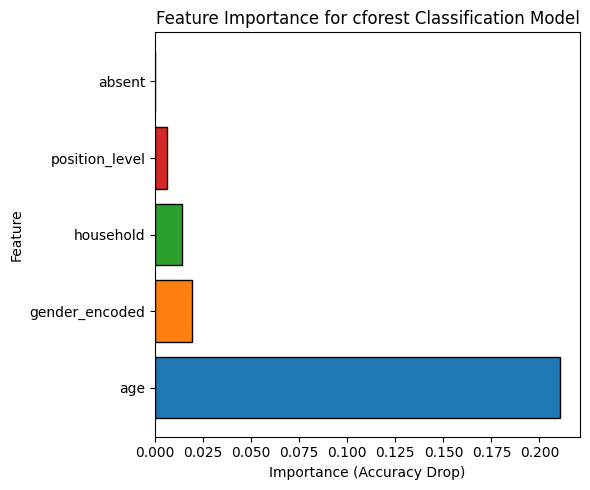

In [19]:
# Plot feature importance
plot_feature_importance(feature_importance, predictors, forest_model['task_type'])

#### Hyperparameter Tuning for cforest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

1. Define Control Prameters

In [ ]:
# Define control parameters with defaults
control = {
    "teststat": "quad",
    "testtype": "Univ",
    "mincriterion": 0.01,
    "saveinfo": False,
    "n_perm": 50,
    "cores": 4
}


2. Define hyperparameter grid

In [ ]:
# Define hyperparameter grid
param_grid = {
    'ntree': [50, 100, 200],
    'mtry': [int(np.sqrt(len(available_predictors))), len(available_predictors) // 2, len(available_predictors)],
    'max_depth': [5, 10, 15]
}

3. Perform grid search

In [ ]:
# Perform grid search
results = []
print("Performing grid search for classification...")
for params in ParameterGrid(param_grid):
    try:
        # Update control with max_depth
        control['max_depth'] = params['max_depth']
        # Fit cforest model
        forest_model = cforest(
            formula=formula,
            data=train,
            ntree=params['ntree'],
            mtry=params['mtry'],
            perturb={"replace": False, "fraction": [0.632]},
            cores=4,
            trace=False
        )
        # Compute OOB predictions
        oob_predictions = forest_model['predict'](train[available_predictors], default_prediction=forest_model['default_prediction'])
        oob_accuracy = accuracy_score(train['product'].values, oob_predictions)
        results.append({
            'ntree': params['ntree'],
            'mtry': params['mtry'],
            'max_depth': params['max_depth'],
            'oob_accuracy': oob_accuracy
        })
        print(f"ntree={params['ntree']}, mtry={params['mtry']}, max_depth={params['max_depth']}, OOB Accuracy={oob_accuracy:.4f}")
    except Exception as e:
        print(f"Error for params {params}: {e}")
        continue

4. Find best parameters

In [ ]:
# Find best parameters
best_result = max(results, key=lambda x: x['oob_accuracy'])
print(f"\nBest parameters: ntree={best_result['ntree']}, mtry={best_result['mtry']}, max_depth={best_result['max_depth']}, OOB Accuracy={best_result['oob_accuracy']:.4f}")

5.Fit model with best parameters

In [ ]:
# Fit model with best parameters
try:
    print("\nFitting cforest model with best parameters...")
    cforest_final = cforest(
        formula=formula,
        data=train,
        ntree=best_result['ntree'],
        mtry=best_result['mtry'],
        perturb={"replace": False, "fraction": [0.632]},
        cores=4,
        trace=True
    )
except Exception as e:
    print(f"Error in fitting best model: {e}")
    exit()


6. Prediction and Evaluation

In [ ]:
# Predict on test set
try:
    predictions = cforest_final['predict'](test[available_predictors], default_prediction=cforest_final['default_prediction'])
except Exception as e:
    print(f"Error in prediction: {e}")
    exit()

# Evaluate classification performance
true_labels = test['product'].values
print("\nClassification Performance (Test Set):")
print(f"Accuracy: {accuracy_score(true_labels, predictions):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, predictions))
print("\nClassification Report:")
print(classification_report(true_labels, predictions))

7. Feature Importance

In [7]:
# Compute feature importance
print("\nComputing feature importance...")
feature_importance_final = compute_feature_importance(cforest_final, test, predictors, true_labels, cforest_final['task_type'], n_permutations=5)
print("\nFeature Importance Scores:")
for feature, score in feature_importance.items():
    print(f"{feature}: {score:.4f}")


Computing feature importance...

Feature Importance Scores:
age: 0.2023
household: 0.0152
position_level: 0.0087
absent: -0.0018
gender_encoded: 0.0170


### Regression Example

This section demonstrates how to use the custom cforest function for a regression task.

#### Data

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score


# Load and prepare Boston Housing data
boston = fetch_openml(name='boston', version=1, as_frame=True)
df = boston.frame

# Set random seed for reproducibility
np.random.seed(123)

# Select relevant columns
df = df[['MEDV', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']]

# Convert CHAS to category
df['CHAS'] = df['CHAS'].astype('category')

# Ensure RAD and TAX are numeric
df['RAD'] = df['RAD'].astype(float)
df['TAX'] = df['TAX'].astype(float)

# Apply one-hot encoding to CHAS
df = pd.get_dummies(df, columns=['CHAS'], drop_first=True)

# Split data into training (70%) and test (30%) sets
train, test = train_test_split(df, train_size=0.70, random_state=101)

# Feature scaling
scaler = StandardScaler()
numeric_cols = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
train[numeric_cols] = scaler.fit_transform(train[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])

# Define predictors
predictors = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'CHAS_1']
available_predictors = [col for col in predictors if col in train.columns and col in test.columns]
formula = f"MEDV ~ {' + '.join(available_predictors)}"

#### Fit cforest Regression Model

In [21]:
# Define control parameters
control = {
    "teststat": "quad",
    "testtype": "Univ",
    "mincriterion": 0.01,
    "max_depth": 10,
    "saveinfo": False,
    "n_perm": 50,
    "cores": 4
}

# Fit cforest model
try:
    print("Fitting cforest model for regression...")
    forest_model = cforest(
        formula=formula,
        data=train,
        ntree=100,
        mtry=None,
        perturb={"replace": False, "fraction": [0.632]},
        cores=4,
        trace=True
    )
except Exception as e:
    print(f"Error in fitting cforest model: {e}")
    exit()

Fitting cforest model for regression...
Detected task: regression


100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


#### Predict on the Test Data

In [22]:
# Predict on test set
try:
    predictions = forest_model['predict'](test[available_predictors], default_prediction=forest_model['default_prediction'])
except Exception as e:
    print(f"Error in prediction: {e}")
    exit()


#### Evaluate Model

In [23]:
# Evaluate regression performance
true_labels = test['MEDV'].values
mse = mean_squared_error(true_labels, predictions)
r2 = r2_score(true_labels, predictions)
print("\nRegression Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")



Regression Performance:
Mean Squared Error (MSE): 105.0163
R² Score: -0.0580


#### Feature Importnace

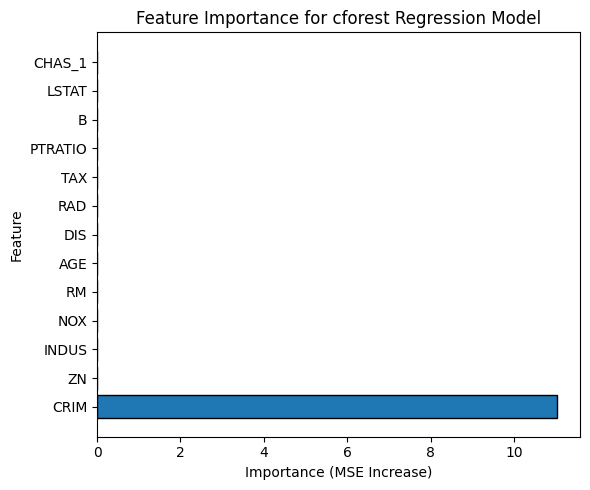

In [24]:
# Compute and plot feature importance
forest_model['task_type'] = 'regression'
try:
    importance = compute_feature_importance(forest_model, test, available_predictors, true_labels, task_type='regression')
    plot_feature_importance(importance, available_predictors, task_type='regression')
except Exception as e:
    print(f"Error in computing feature importance: {e}")

## Summary and Conclusion

This notebook provides a comprehensive overview and custom implementation of the Conditional Random Forest (cforest) algorithm in Python, inspired by the `partykit` package in R.

**Summary:**

- The notebook begins with a detailed theoretical explanation of cforest, highlighting its use of conditional inference trees and its advantages over traditional Random Forests, particularly in unbiased variable selection.
- A custom Python implementation of the `cforest` algorithm and its supporting functions (`ctree`, `predict_forest`, `compute_feature_importance`, etc.) is presented and explained.
- Two practical examples demonstrate the application of the custom `cforest` function:
    - **Classification Example:** Using a health insurance dataset to predict product type based on various features. The model's performance is evaluated using accuracy, confusion matrix, and classification report. Permutation-based feature importance is computed and visualized.
    - **Regression Example:** Using the Boston Housing dataset to predict median house value. The model's performance is evaluated using Mean Squared Error (MSE) and R-squared. Permutation-based feature importance is also computed and visualized for this task.
- Hyperparameter tuning for the classification example is performed using a grid search approach to find optimal values for `ntree`, `mtry`, and `max_depth` based on Out-of-Bag (OOB) accuracy.

**Conclusion:**

The custom `cforest` implementation in this notebook successfully demonstrates the core principles of conditional inference forests in Python. While the performance on the provided examples (health insurance classification and Boston Housing regression) might not be superior to highly optimized implementations in libraries like scikit-learn, the notebook serves as a valuable educational resource for understanding the internal workings of cforest. The implementation allows for exploring the impact of conditional inference and permutation tests on tree building and variable importance. The hyperparameter tuning section illustrates a practical approach to improving model performance. Overall, this notebook provides a solid foundation for understanding and experimenting with conditional random forests in a Python environment.

## References

1.  Hothorn, T., Hornik, K., & Zeileis, A. (2006). Unbiased Recursive Partitioning: A Conditional Inference Framework. *Journal of Computational and Graphical Statistics, 15*(3), 651–674.

2.  Strobl, C., Boulesteix, A.-L., Zeileis, A., & Hothorn, T. (2007). Bias in Random Forest Variable Importance Measures: Illustrations, Sources and a Solution. *BMC Bioinformatics, 8*(25).

3.  Hothorn, T., & Zeileis, A. (2015). partykit: A Modular Toolkit for Recursive Partytioning in R. *The Journal of Machine Learning Research, 16*(1), 3905–3909.

4.  Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning: Data Mining, Inference, and Prediction* (2nd ed.). Springer.


